In [1]:
import json
import os
from typing import Optional
from urllib.parse import urlparse

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from publicsuffixlist import PublicSuffixList
from tqdm import tqdm

from apk_analysis.data import APKAnalysisResult, AndroidPermissions, AndroidPermission, AndroidAPIPermission, AndroidProvider, AndroidAPI, APIPermissionGroup, Tracker
from apk_analysis.utils import list_all_json

sns.set_theme()


In [2]:
APK_DUMP_DIR = os.path.join(".", "resources", "apk_dump")
CONSTANTS_DIR = os.path.join(".", "resources", "dataset", "constants")
SUPPORTED_SDK = list(range(26, 33 + 1))
PERMISSIONS_SDK_PATHS = [os.path.join(CONSTANTS_DIR, "permissions", f"permissions-{i}.json") for i in SUPPORTED_SDK]
MAPPINGS_SDK_PATHS = [os.path.join(CONSTANTS_DIR, "permission_mappings", f"sdk-{i}.json") for i in SUPPORTED_SDK]
PERMISSIONS_REL_PATH = os.path.join(CONSTANTS_DIR, "permissions", "permissions-REL.json")
PERMISSION_PROVIDERS_PATH = os.path.join(CONSTANTS_DIR, "providers", "permission_providers.json")

PSL = PublicSuffixList(only_icann=True)
STOP_HOSTS = {
    "android.com",
    "www.android.com",
    "tools.android.com",
    "cs.android.com",
    "source.android.com",
    "developer.android.com",
    "javax.xml.xmlconstants",
    "www.w3.org",
    "xmlpull.org",
    "apache.org",
    "xml.apache.org",
    "commons.apache.org",
    "www.slf4j.org",
    "xml.org",
}


In [3]:
def save_plt(name: str, prefix: str = "permissions", dir_path: str = "figures"):
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
    fig_path = os.path.join(dir_path, f"{prefix}_{name}.pdf")
    plt.savefig(fig_path, format="pdf", bbox_inches="tight")


In [4]:
def load_all_dump_results(path: str) -> list[APKAnalysisResult]:
    all_paths = list_all_json(path)
    result: dict[str, APKAnalysisResult] = {}
    for path in tqdm(all_paths):
        with open(path, "r", encoding="utf-8") as f:
            data = APKAnalysisResult.from_json(f.read())
            if data.manifest.package_name not in result or result[data.manifest.package_name].manifest.version_code < data.manifest.version_code:
                result[data.manifest.package_name] = data
    return list(result.values())


ANALYSIS_RESULTS = load_all_dump_results(APK_DUMP_DIR)
print("Load size:", len(ANALYSIS_RESULTS))


100%|██████████| 1821/1821 [00:12<00:00, 148.49it/s]

Load size: 1821


In [5]:
def load_permissions(path: str) -> AndroidPermissions:
    with open(path, "r", encoding="utf-8") as f:
        return AndroidPermissions.from_json(f.read())


def get_sdk_permissions(permissions: AndroidPermissions) -> set[str]:
    return {
        p
        for p, d in permissions.permissions.items()
        if "signature" not in d.protection_levels and "signatureOrSystem" not in d.protection_levels and "privileged" not in d.protection_levels
    }


ANDROID_PERMISSIONS = load_permissions(PERMISSIONS_REL_PATH)
print("Load:", len(ANDROID_PERMISSIONS.permissions))
SDK_PERMISSIONS = get_sdk_permissions(ANDROID_PERMISSIONS)
print("SDK:", len(get_sdk_permissions(ANDROID_PERMISSIONS)))


Load: 766
SDK: 134


In [6]:
def calculate_strings_frequency(data: list[str]) -> dict[str, int]:
    result: dict[str, int] = {}
    for i in data:
        if i is not None:
            if i in result:
                result[i] += 1
            else:
                result[i] = 1
    return result


def get_counter_x_y(counter: dict[str, int], k: Optional[int] = None, others: bool = True) -> tuple[list[str], list[int]]:
    sorted_data = sorted(counter.items(), key=lambda item: item[1], reverse=True)
    if k is None or k == len(sorted_data):
        x = list([i[0] for i in sorted_data])
        y = list([i[1] for i in sorted_data])
    else:
        top_k = sorted_data[:k]
        x = list([i[0] for i in top_k])
        y = list([i[1] for i in top_k])
        if others:
            others_value = sum([i[1] for i in sorted_data[k:]])
            x += ["Others"]
            y += [others_value]
    return x, y


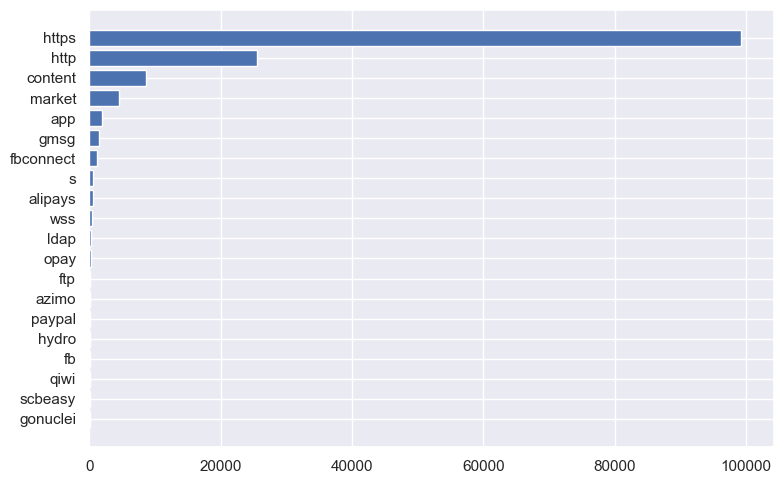

In [19]:
def plot_top_k_scheme_usage(analysis_results: list[APKAnalysisResult], k: int = 20):
    plt.figure(figsize=(8, 5))
    all_uris_schemes = [
        u.scheme
        for u in [urlparse(i) for r in analysis_results for i in r.strings.uris]
        if u.scheme is not None and u.hostname not in STOP_HOSTS
    ]
    counter = calculate_strings_frequency(all_uris_schemes)
    x, y = get_counter_x_y(counter, k, False)
    plt.barh(x, y)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    save_plt("scheme")
    plt.show()


plot_top_k_scheme_usage(ANALYSIS_RESULTS)


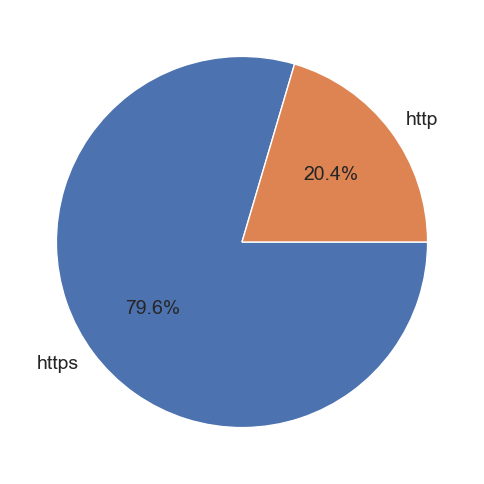

In [7]:
def plot_http_scheme_usage(analysis_results: list[APKAnalysisResult]):
    plt.figure(figsize=(5, 5))
    http_https_schemes = {"http", "https"}
    all_uris_schemes = [
        u.scheme
        for u in [urlparse(i) for r in analysis_results for i in r.strings.uris]
        if u.scheme is not None and u.hostname not in STOP_HOSTS and u.scheme in http_https_schemes
    ]
    counter = calculate_strings_frequency(all_uris_schemes)
    x, y = get_counter_x_y(counter)
    plt.pie(y, labels=x, autopct='%1.1f%%', textprops={'fontsize': 14})
    plt.gca().invert_yaxis()
    plt.tight_layout()
    save_plt("http")
    plt.show()


plot_http_scheme_usage(ANALYSIS_RESULTS)


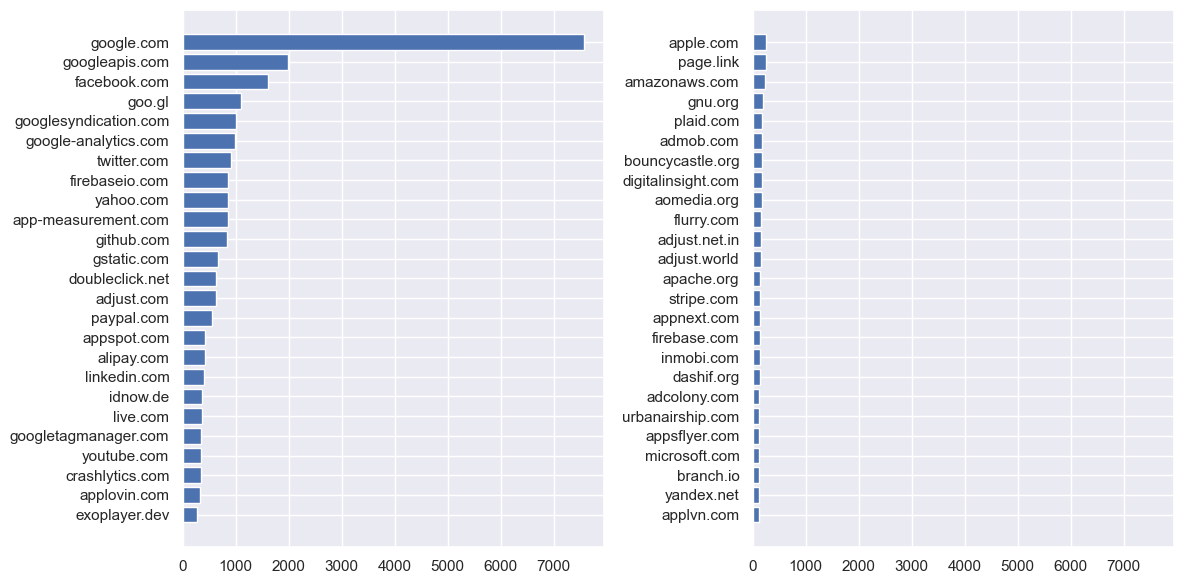

In [8]:
def plot_top_k_web_host_usage(analysis_results: list[APKAnalysisResult], k: int = 50):
    schemes = {"http", "https", "wss", "ftp"}
    all_uris_hosts = [
        h
        for r in analysis_results for h in
        {
            i.hostname
            for i in [urlparse(u) for u in r.strings.uris]
            if i.scheme in schemes and i.hostname is not None and i.hostname not in STOP_HOSTS
        }
        if h is not None
    ]
    all_uris_hosts = [j for j in [PSL.privatesuffix(i) for i in all_uris_hosts] if j is not None]
    counter = calculate_strings_frequency(all_uris_hosts)
    y, w = get_counter_x_y(counter, k, False)
    half = len(y) // 2
    _, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharex='all')
    axes[0].barh(y[:half], w[:half])
    axes[1].barh(y[half:], w[half:])
    axes[0].invert_yaxis()
    axes[1].invert_yaxis()
    plt.tight_layout()
    save_plt("hosts")
    plt.show()


plot_top_k_web_host_usage(ANALYSIS_RESULTS)


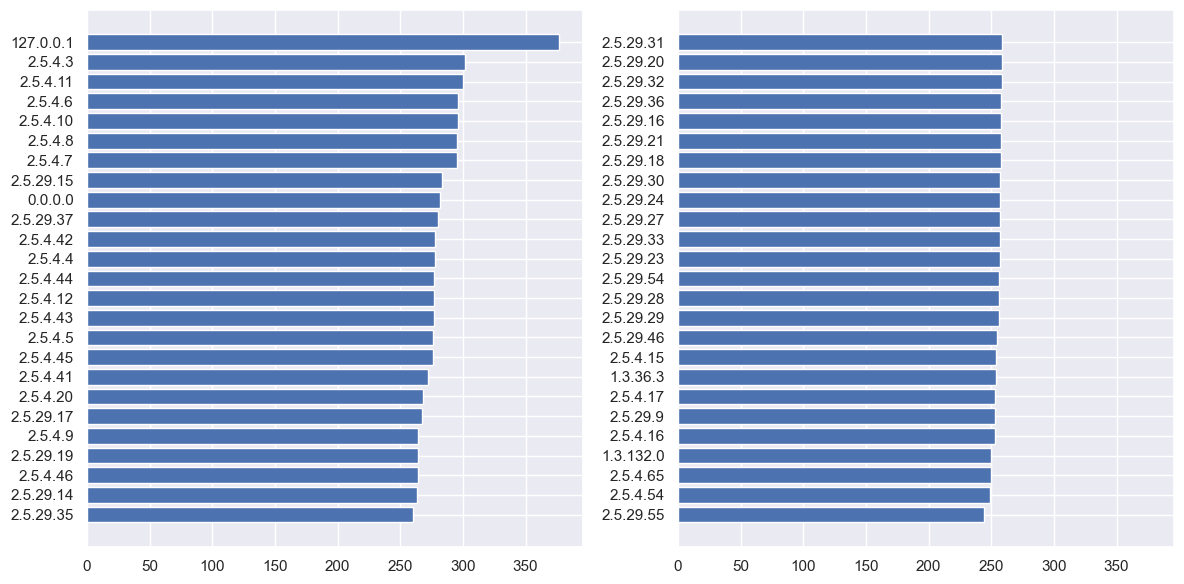

In [9]:
def plot_top_k_ipv4_usage(analysis_results: list[APKAnalysisResult], k: int = 50):
    all_ipv4 = [
        h
        for r in analysis_results for h in set(r.strings.ipv4)
        if h is not None
    ]
    counter = calculate_strings_frequency(all_ipv4)
    y, w = get_counter_x_y(counter, k, False)
    half = len(y) // 2
    _, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharex='all')
    axes[0].barh(y[:half], w[:half])
    axes[1].barh(y[half:], w[half:])
    axes[0].invert_yaxis()
    axes[1].invert_yaxis()
    plt.tight_layout()
    save_plt("ipv4")
    plt.show()


plot_top_k_ipv4_usage(ANALYSIS_RESULTS)


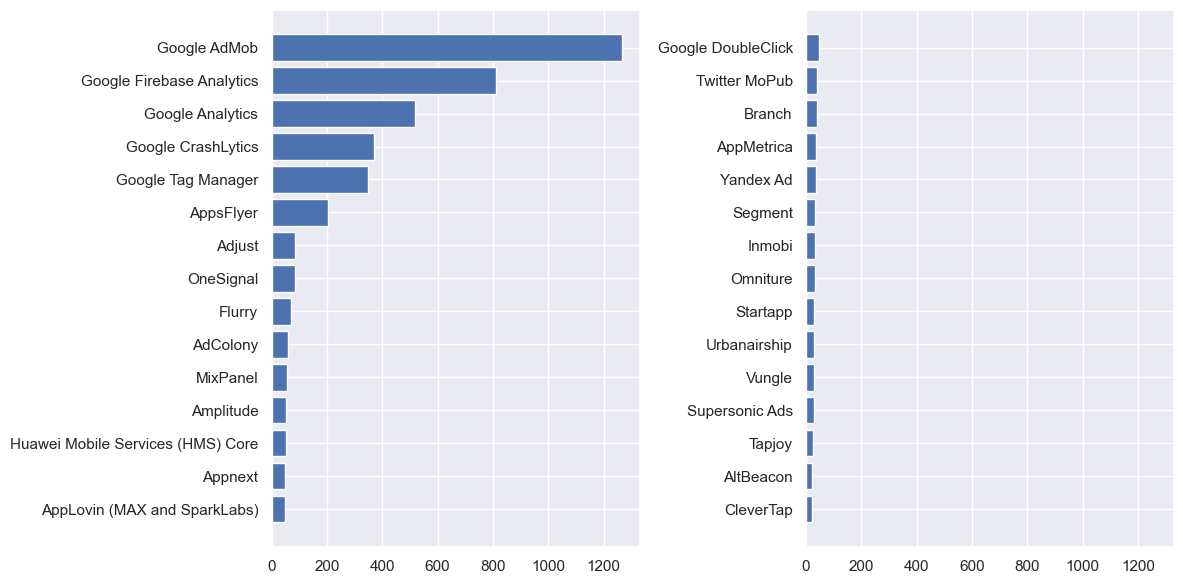

In [22]:
def plot_top_k_tracker_usage(analysis_results: list[APKAnalysisResult], k: int = 30):
    all_trackers = [
        t
        for r in analysis_results for t in set(r.trackers)
        if t is not None
    ]
    counter: dict[Tracker, int] = {}
    for i in all_trackers:
        if i is not None:
            if i in counter:
                counter[i] += 1
            else:
                counter[i] = 1
    sorted_data = sorted(counter.items(), key=lambda item: item[1], reverse=True)
    top_k = sorted_data[:k]
    y = list([i[0].name for i in top_k])
    w = list([i[1] for i in top_k])
    half = len(y) // 2
    _, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharex='all')
    axes[0].barh(y[:half], w[:half])
    axes[1].barh(y[half:], w[half:])
    axes[0].invert_yaxis()
    axes[1].invert_yaxis()
    plt.tight_layout()
    save_plt("tracker")
    plt.show()


plot_top_k_tracker_usage(ANALYSIS_RESULTS)


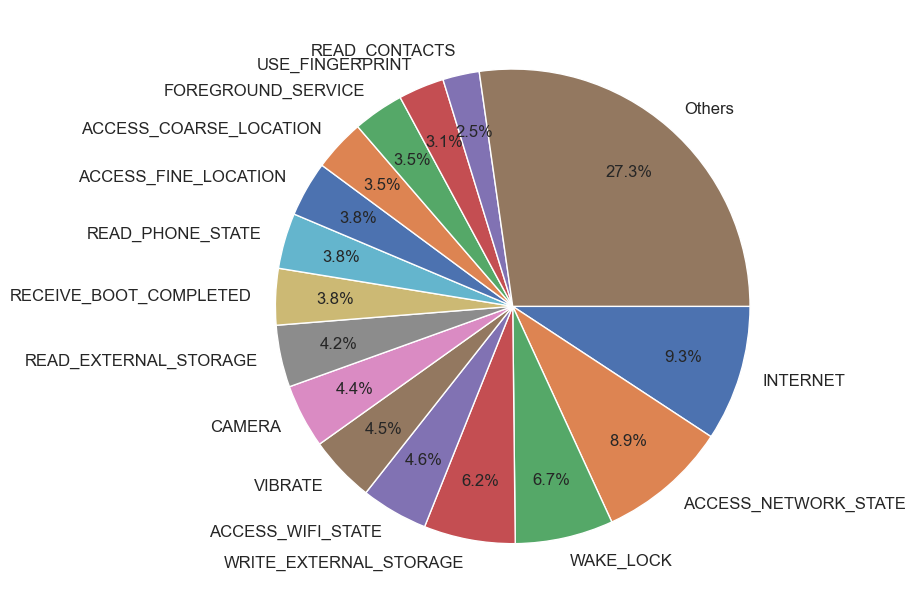

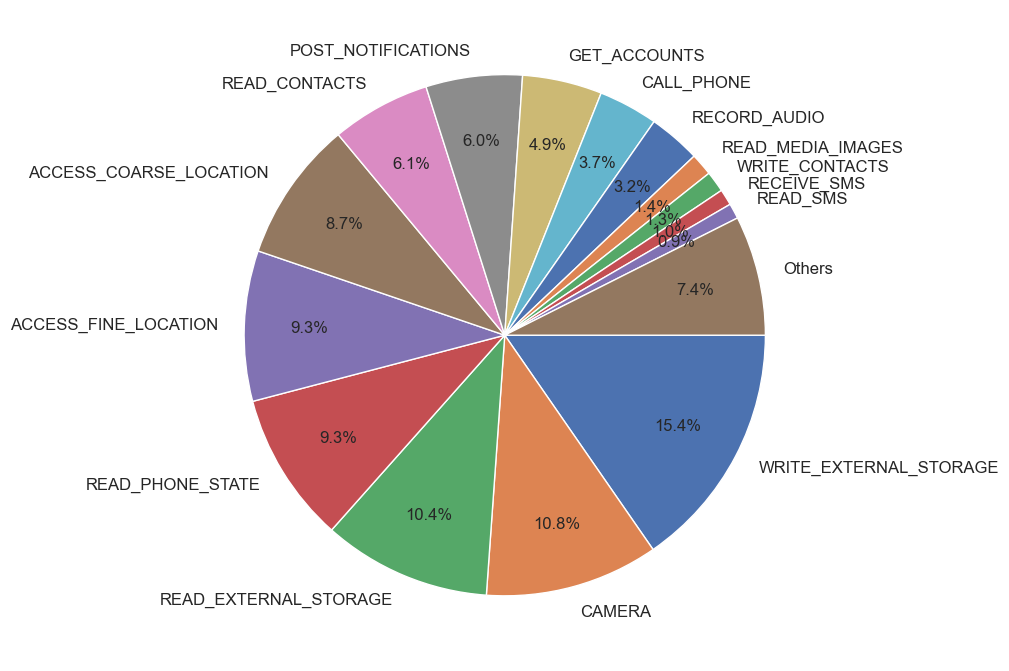

In [23]:
def plot_top_k_use_permission_usage(analysis_results: list[APKAnalysisResult], permissions: AndroidPermissions, k: int = 15):
    android_permission_prefix = "android.permission."
    all_permissions = [
        p
        for i in analysis_results
        for p in set(i.manifest.use_permissions)
        if p.startswith(android_permission_prefix) and \
           p in SDK_PERMISSIONS
    ]
    all_counter = calculate_strings_frequency(all_permissions)

    filtered_permissions = [
        p
        for p in all_permissions
        if "dangerous" in permissions.permissions[p].protection_levels
    ]
    filtered_counter = calculate_strings_frequency(filtered_permissions)

    all_x, all_y = get_counter_x_y(all_counter, k)
    filtered_x, filtered_y = get_counter_x_y(filtered_counter, k)

    all_x = [i[len(android_permission_prefix):] if i != "Others" else i for i in all_x]
    filtered_x = [i[len(android_permission_prefix):] if i != "Others" else i for i in filtered_x]

    plt.figure(figsize=(9, 9))
    plt.pie(all_y, labels=all_x, autopct='%1.1f%%', textprops={'fontsize': 12}, pctdistance=0.75)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    save_plt("use_permissions")
    plt.show()

    plt.figure(figsize=(10, 10))
    plt.pie(filtered_y, labels=filtered_x, autopct='%1.1f%%', textprops={'fontsize': 12}, pctdistance=0.75)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    save_plt("dangerous_use_permissions")
    plt.show()


plot_top_k_use_permission_usage(ANALYSIS_RESULTS, ANDROID_PERMISSIONS)


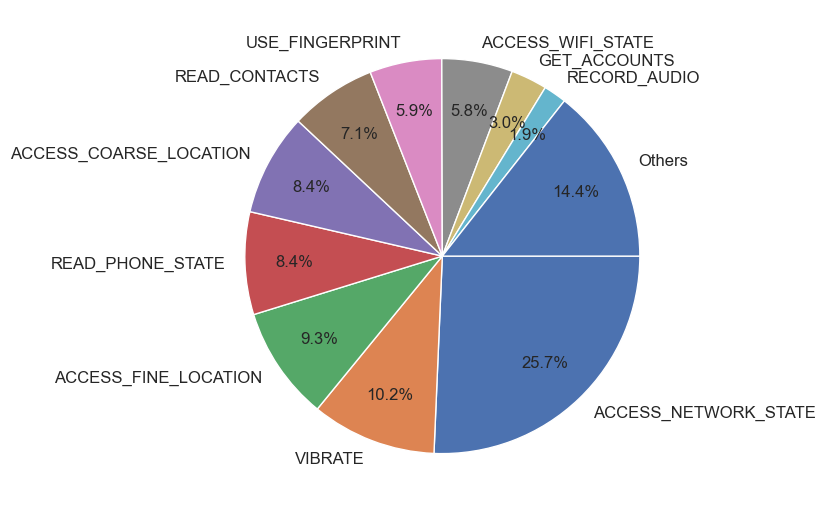

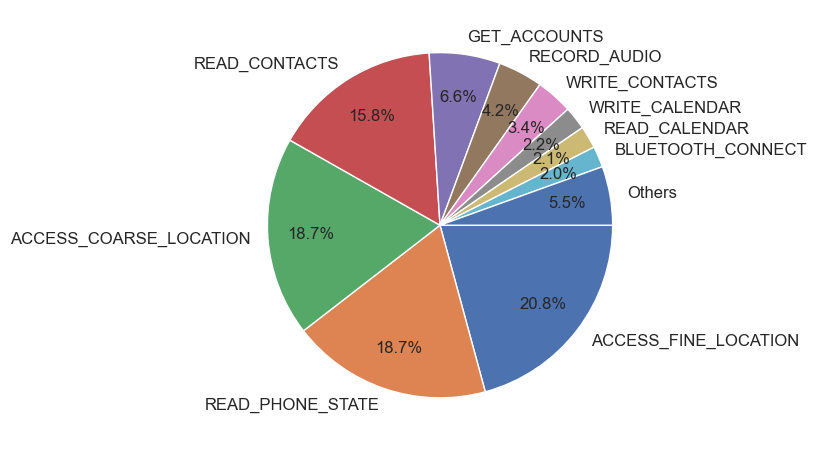

In [12]:
def plot_top_k_code_permission_usage(analysis_results: list[APKAnalysisResult], permissions: AndroidPermissions, k: int = 10):
    android_permission_prefix = "android.permission."
    all_permissions = [
        p
        for i in analysis_results
        for p in set(i.dex_api_permissions.api_call_permissions + i.dex_api_permissions.content_provider_permissions)
        if p.startswith(android_permission_prefix) and \
           p in SDK_PERMISSIONS and \
           p in i.manifest.use_permissions
    ]
    all_counter = calculate_strings_frequency(all_permissions)

    filtered_permissions = [
        p
        for p in all_permissions
        if "dangerous" in permissions.permissions[p].protection_levels
    ]
    filtered_counter = calculate_strings_frequency(filtered_permissions)

    all_x, all_y = get_counter_x_y(all_counter, k)
    filtered_x, filtered_y = get_counter_x_y(filtered_counter, k)

    all_x = [i[len(android_permission_prefix):] if i != "Others" else i for i in all_x]
    filtered_x = [i[len(android_permission_prefix):] if i != "Others" else i for i in filtered_x]

    plt.figure(figsize=(8, 8))
    plt.pie(all_y, labels=all_x, autopct='%1.1f%%', textprops={'fontsize': 12}, pctdistance=0.75)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    save_plt("detected_permissions")
    plt.show()

    plt.figure(figsize=(8, 8))
    plt.pie(filtered_y, labels=filtered_x, autopct='%1.1f%%', textprops={'fontsize': 12}, pctdistance=0.75)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    save_plt("dangerous_detected_permissions")
    plt.show()


plot_top_k_code_permission_usage(ANALYSIS_RESULTS, ANDROID_PERMISSIONS)


Avg accuracy: 0.33389333855455605


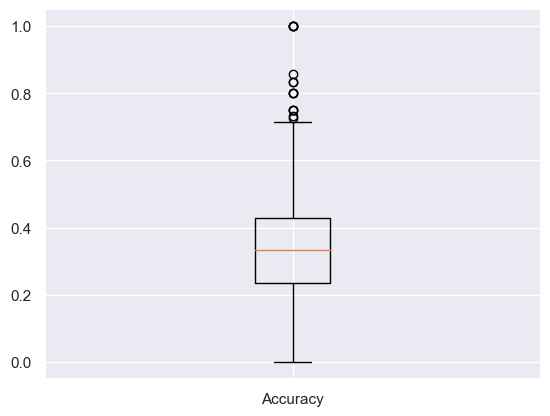

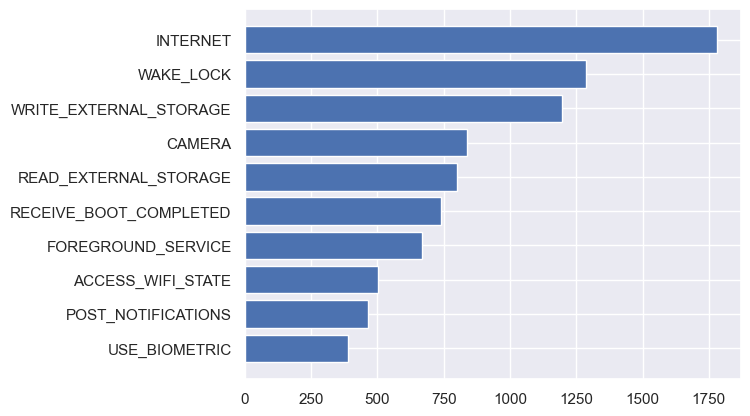

Avg accuracy: 0.3109300519241908


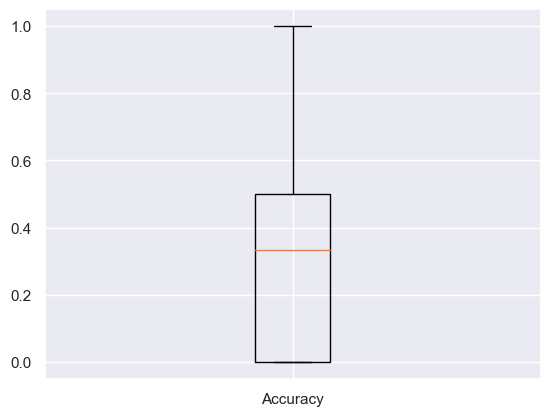

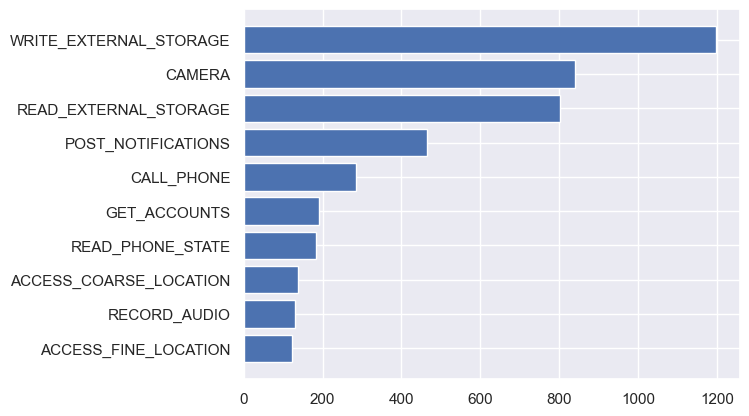

In [13]:
def get_android_permissions(r: APKAnalysisResult, permissions: dict[str, AndroidPermission], is_filtered: bool) -> tuple[set[str], set[str]]:
    android_permission_prefix = "android.permission."
    use_permissions = {
        i
        for i in set(r.manifest.use_permissions)
        if i.startswith(android_permission_prefix) and i in SDK_PERMISSIONS and \
           (not is_filtered or "dangerous" in permissions[i].protection_levels)
    }
    dex_permissions = {
        i
        for i in set(r.dex_api_permissions.api_call_permissions + r.dex_api_permissions.content_provider_permissions)
        if i.startswith(android_permission_prefix) and i in SDK_PERMISSIONS and i in use_permissions and \
           (not is_filtered or "dangerous" in permissions[i].protection_levels)
    }
    return use_permissions, dex_permissions


def plot_actual_detect_android_permissions(analysis_results: list[APKAnalysisResult], permissions: dict[str, AndroidPermission], is_filtered: bool):
    android_permission_prefix = "android.permission."

    tps: list[float] = []
    fn_permissions: list[str] = list()
    for r in analysis_results:
        use_permissions, dex_permissions = get_android_permissions(r, permissions, is_filtered)
        if len(use_permissions) != 0:
            tps.append(len(use_permissions & dex_permissions) / len(use_permissions))
            fn_permissions.extend(use_permissions - dex_permissions)

    fn_counter = calculate_strings_frequency(fn_permissions)
    fn_x, fn_y = get_counter_x_y(fn_counter, 10, False)
    fn_x = [i[len(android_permission_prefix):] if i != "Others" else i for i in fn_x]

    print("Avg accuracy:", sum(tps) / len(tps))
    
    plt.boxplot(tps)
    plt.gca().set_xticklabels(['Accuracy'])
    if is_filtered:
        save_plt("accuracy_dangerous_detected_permissions")
    else:
        save_plt("accuracy_detected_permissions")
    plt.show()

    plt.barh(fn_x, fn_y)
    plt.gca().invert_yaxis()
    if is_filtered:
        save_plt("failed_dangerous_detected_permissions")
    else:
        save_plt("failed_detected_permissions")
    plt.show()


plot_actual_detect_android_permissions(ANALYSIS_RESULTS, ANDROID_PERMISSIONS.permissions, False)
plot_actual_detect_android_permissions(ANALYSIS_RESULTS, ANDROID_PERMISSIONS.permissions, True)


In [14]:
def load_api_permissions(path: str) -> list[AndroidAPIPermission]:
    with open(path, "r", encoding="utf-8") as f:
        content = json.load(f)
        return [
            AndroidAPIPermission(
                api=AndroidAPI.api_type_decoder(p["api"]),
                permission_groups=APIPermissionGroup.schema().load(p["permission_groups"], many=True)
            )
            for p in content
        ]


def load_providers(path: str) -> list[AndroidProvider]:
    with open(path, "r", encoding="utf-8") as f:
        return AndroidProvider.schema().loads(f.read(), many=True)


VERSION_PERMISSIONS = [load_permissions(p) for p in PERMISSIONS_SDK_PATHS]
SDK_VERSION_PERMISSIONS = [get_sdk_permissions(p) for p in VERSION_PERMISSIONS]
API_VERSION_PERMISSIONS = [load_api_permissions(p) for p in MAPPINGS_SDK_PATHS]
PROVIDER_PERMISSIONS = load_providers(PERMISSION_PROVIDERS_PATH)


In [15]:
def count_permissions(
        version_permissions: list[AndroidPermissions],
        sdk_version_permissions: list[set[str]],
        mapping_permissions: list[list[AndroidAPIPermission]],
        provider_permissions: list[AndroidProvider]
) -> pd.DataFrame:
    assert len(sdk_version_permissions) == len(mapping_permissions)
    result: list[tuple[int, int, int, int, int]] = []
    pp: set[str] = {j for i in provider_permissions for j in i.all_permissions}
    for vp, sp, mp in zip(version_permissions, sdk_version_permissions, mapping_permissions):
        vp: AndroidPermissions
        sp: set[str]
        mp: list[AndroidAPIPermission]

        ap_c = len(vp.permissions)
        sp_c = len(sp)
        sp_d_c = len({i for i in sp if "dangerous" in vp.permissions[i].protection_levels})

        ps = {k for i in mp for j in i.permission_groups for k in j.permissions if k in sp}
        ps.update({i for i in pp if i in sp})
        p_c = len(ps)
        p_d_c = len({i for i in ps if "dangerous" in vp.permissions[i].protection_levels})

        result.append((ap_c, sp_c, sp_d_c, p_c, p_d_c))
    headers = ["All", "SDK", "Dangerous SDK", "Detected", "Dangerous detected"]
    return pd.DataFrame(result, columns=headers, index=SUPPORTED_SDK)


def calculate_count_permissions(df: pd.DataFrame) -> pd.DataFrame:
    out = pd.DataFrame(index=SUPPORTED_SDK)
    out["SDK / All"] = df["SDK"] / df["All"]
    out["Dangerous SDK"] = df["Dangerous SDK"] / df["SDK"]
    out["Detected / SDK"] = df["Detected"] / df["SDK"]
    out["Dangerous detected"] = df["Dangerous detected"] / df["Detected"]
    out["Dangerous detected / Dangerous SDK"] = df["Dangerous detected"] / df["Dangerous SDK"]
    return out


PERMISSION_COUNT = count_permissions(VERSION_PERMISSIONS, SDK_VERSION_PERMISSIONS, API_VERSION_PERMISSIONS, PROVIDER_PERMISSIONS)
PERMISSION_COUNT


,All,SDK,Dangerous SDK,Detected,Dangerous detected
26,387,84,27,42,16
27,407,84,27,42,16
28,457,88,28,41,18
29,534,94,31,43,18
30,592,94,31,43,17
31,689,115,35,49,21
32,693,115,35,49,21
33,766,135,41,56,23


In [16]:
PERMISSION_RATE_COUNT = calculate_count_permissions(PERMISSION_COUNT)
PERMISSION_RATE_COUNT


,SDK / All,Dangerous SDK,Detected / SDK,Dangerous detected,Dangerous detected / Dangerous SDK
26,0.217054,0.321429,0.500000,0.380952,0.592593
27,0.206388,0.321429,0.500000,0.380952,0.592593
28,0.192560,0.318182,0.465909,0.439024,0.642857
29,0.176030,0.329787,0.457447,0.418605,0.580645
30,0.158784,0.329787,0.457447,0.395349,0.548387
31,0.166909,0.304348,0.426087,0.428571,0.600000
32,0.165945,0.304348,0.426087,0.428571,0.600000
33,0.176240,0.303704,0.414815,0.410714,0.560976


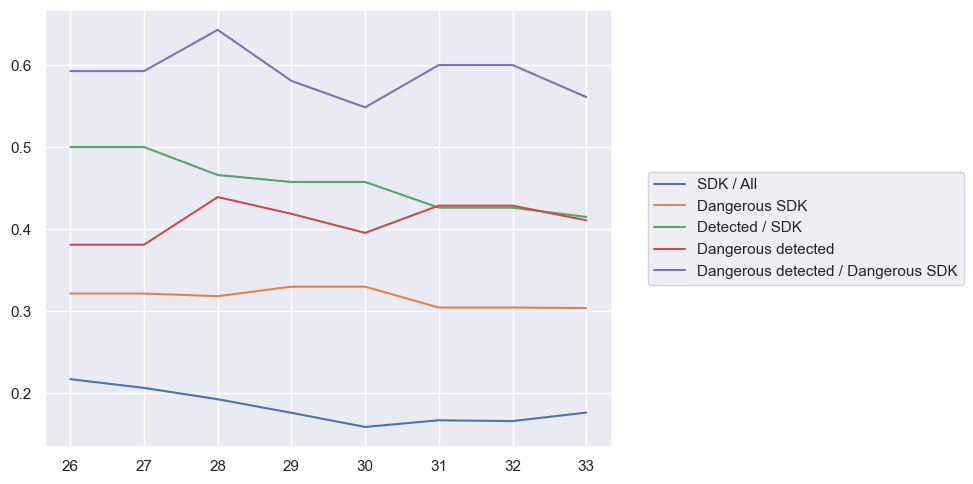

In [17]:
PERMISSION_RATE_COUNT.plot(figsize=(10, 5))
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
plt.tight_layout()
save_plt("permissions_rate")
plt.show()
